In [5]:
%matplotlib notebook
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifelines
from lifelines import KaplanMeierFitter, statistics
import numpy as np
import re
import subprocess

In [6]:
# Create a dataframe from data stored on GitHub

df = pd.read_csv('ornv-transmission.csv', 
                 parse_dates=[3,4])
#print df.info()

In [7]:
# Create some extra columns
# t is time until death in days after start of bioassay
# e is a boolean indication that the beetle died during the bioassay

df['date_end_bioassay'] = df.date_died.max()
t, e = lifelines.utils.datetimes_to_durations(
    start_times=pd.to_datetime(df.date_treated),
    end_times=pd.to_datetime(df.date_died),
    fill_date=pd.to_datetime(df.date_end_bioassay))
df['t'] = t
df['e'] = e
df

,jar_id,sex,treatment,date_treated,date_died,postmortem_virus,postmortem_bacteria,date_end_bioassay,t,e
0,C1,m,none,2019-12-26,2020-01-16,NaN,NaN,2020-02-06,21.0,True
1,C2,m,none,2019-12-26,2020-01-29,NaN,NaN,2020-02-06,34.0,True
2,C3,m,none,2019-12-26,2020-01-19,NaN,NaN,2020-02-06,24.0,True
3,C4,m,none,2019-12-26,2020-01-21,NaN,NaN,2020-02-06,26.0,True
4,C5,m,none,2019-12-26,2020-01-29,NaN,NaN,2020-02-06,34.0,True
...,...,...,...,...,...,...,...,...,...,...
85,TM11,f,companion,2019-12-27,2020-01-29,NaN,NaN,2020-02-06,33.0,True
86,TM12,f,companion,2019-12-27,NaT,NaN,NaN,2020-02-06,41.0,False
87,TM13,f,companion,2019-12-27,2020-02-03,NaN,NaN,2020-02-06,38.0,True
88,TM14,f,companion,2019-12-27,2020-01-14,NaN,NaN,2020-02-06,18.0,True


<IPython.core.display.Javascript object>


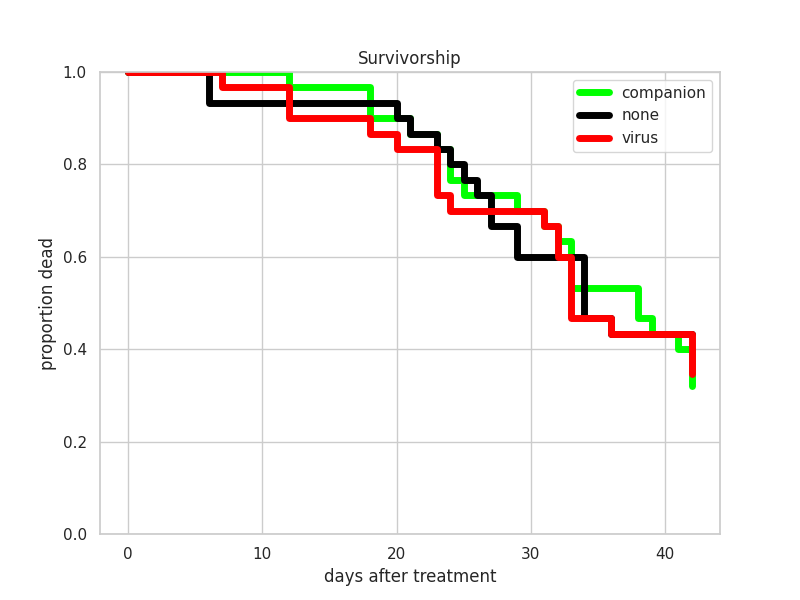

In [8]:
# Generate a survivorship plot.

sns.set()
sns.set_style("whitegrid")

# Create custom palette
colors = ["#00FF00", "#000000","#FF0000", ]
sns.set_palette(sns.color_palette(colors))

# Create survorship plot

fig, ax = plt.subplots(figsize=(8,6))
kmf = KaplanMeierFitter()
for name, grouped_df in df.groupby('treatment'):
    kmf.fit(grouped_df['t'], grouped_df['e'], label=name)
    kmf.plot(ax=ax, linewidth=5, ci_show=False)
ax.set_xlabel('days after treatment')
ax.set_ylabel('proportion dead')
ax.set_ylim([0,1])
ax.set_title('Survivorship');
fig.savefig('survivorship.pdf')

In [9]:
def plot_pairs(tgroup, plot_title):
    """
    Generate a plot showing dates on which partneres were found dead.
    
    tgroup: 'TF' or 'TM'
    plot_title: 'Females dosed with virus' for example
    """
    # Copy the slice where jar_id starts with 'TF'
    dftf = df[df.jar_id.str.startswith(tgroup)].copy()

    # Filter out beetles which did not die
    dftf = dftf[dftf.e]

    # Create 'pair_id' column
    dftf['pair_id'] = dftf.apply(lambda row: int(re.findall('\d+',row.jar_id)[0]), axis=1)

    # Sort so that virus treatments come first
    dftf.sort_values(by='treatment', inplace=True, ascending=False)

    sns.set()
    sns.set_style("whitegrid")

    # Create custom palette
    colors = ["#FF0000", "#00FF00"]
    sns.set_palette(sns.color_palette(colors))

    p = sns.lmplot(x='t', y='pair_id', data=dftf, hue='treatment', fit_reg=False, y_jitter=0.2)
    p = p.set(xlim=(0,43))
    p = p.set(ylim=(0,16))
    p = p.set(yticks=np.arange(1,16,1))
    p = p.set(xticks=np.arange(0,43,4))
    plt.title(plot_title)
    return p

#p = plot_pairs('TF', 'Females dosed with virus')
#p.savefig('tf.pdf')

<IPython.core.display.Javascript object>


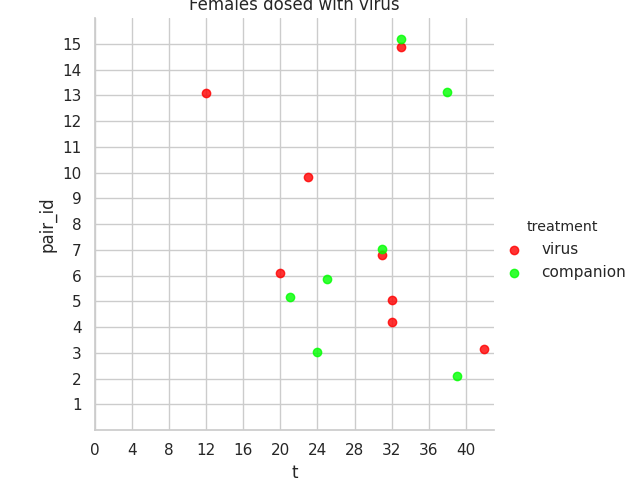

In [10]:


p = plot_pairs('TF', 'Females dosed with virus')
p.savefig('tf.pdf')

<IPython.core.display.Javascript object>


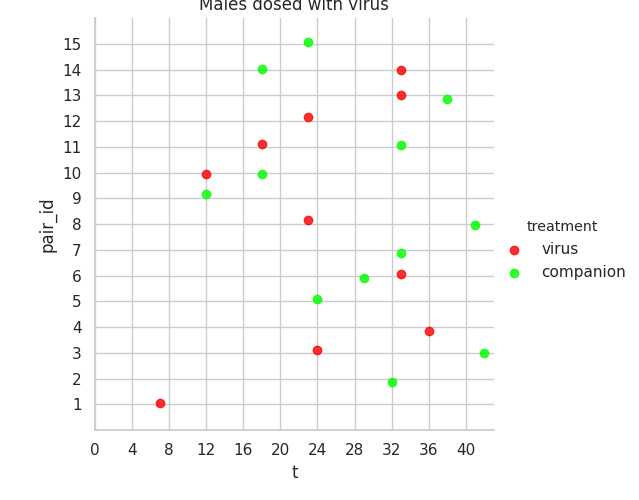

In [11]:
p = plot_pairs('TM', 'Males dosed with virus')
p.savefig('tm.pdf')

In [12]:
# Convert the *.tex file to a PDF. Assumes a TEX package is installed.

subprocess.call(['pdflatex', 'ornv-transmission.tex'])

0

In [13]:
# View the PDF using the default PDF viewer.

subprocess.call(['xdg-open', 'ornv-transmission.pdf'])

0